# bounding_boxes

> Separating scans with multiple distinct drawings

In [ ]:
#| default_exp bounding_boxes

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import os
from itertools import combinations
from pprint import pprint

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

from singleline_stroke3.dataset import *
from singleline_stroke3.display import *
from singleline_stroke3.fileorg import *
from singleline_stroke3.strokes import *
from singleline_stroke3.svg import *
from singleline_stroke3.transforms import *

In [ ]:
#| hide

## Chop the full dataset down to something quicker for testing

# input_path = singleline_data_home(default="../data_home") / "stroke3/epoch-20231214/full-v2-eps10.npz"
# full_dataset = np.load(
#     input_path,
#     encoding="latin1",
#     allow_pickle=True,
# )["arr_0"]


# len(full_dataset)
# print(input_dataset)
# sample_dataset = full_dataset[:20]

# sample_path = singleline_data_home(default="../data_home") / "stroke3/epoch-20231214/sample-v2-eps10.npz"
# np.savez(sample_path, sample_dataset, encoding='latin1', allow_pickle=True)

## The Problem

Many drawings in the dataset represent a single face, where the model can learn to start a drawing and stop when the face is more or less completed.

However, some scans include a page where I drew multiple drawings. Looking at the full image below, it seems that two of the strokes (purple and green) are obviously connected as part of the same "drawing".

However, the blue, red, and orange strokes seem distinct - there's a significant amount of space between them. Intuitively, if I drew a box around each sub-drawing (based on the minimum and maximum X and Y coordinate values), I could quantity how much overlap exists.

no env var SINGLELINE_DATA_HOME, defaulting to: None


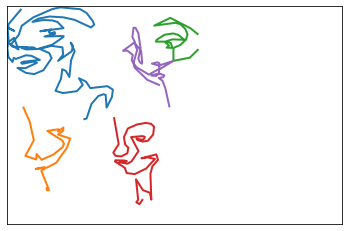

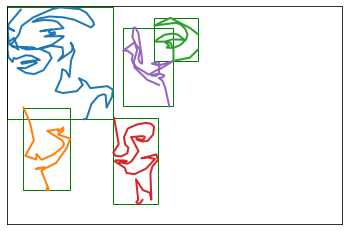

This drawing has 5 distinct strokes


In [ ]:
data_home = singleline_data_home(default="../data_home")

sample_path = data_home / "stroke3/epoch-20231214/sample-v2-eps10.npz"

full_dataset = np.load(
    sample_path,
    encoding="latin1",
    allow_pickle=True,
)["arr_0"]

s0 = deltas_to_strokes(full_dataset[0])

plot_strokes(s0)
plot_strokes(s0, bounding_boxes=True)

print(f"This drawing has {len(s0)} distinct strokes")

BBox((96.63026729741347, 10.718543770600853), (125.19782419420726, 54.38382939025482)) (width 28.56755689679379 x height 43.665285619653964)
BBox((76.1019055995039, 20.73623921702644), (109.21657860962235, 100.64026618156714)) (width 33.11467301011845 x height 79.9040269645407)


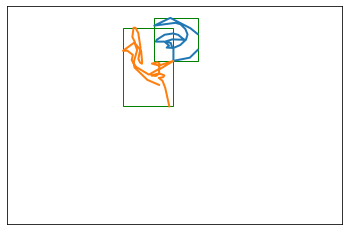

In [ ]:
# make a shorthand for individual strokes within the drawing
s00 = s0[0]
s01 = s0[1]
s02 = s0[2]
s03 = s0[3]
s04 = s0[4]

bb02 = BoundingBox.create(s02)
bb04 = BoundingBox.create(s04)

print(bb02)
print(bb04)

plot_strokes([s02, s04], bounding_boxes=True)

## Intersections between Bounding Boxes

Now I'd like to visualize the intersection between these two bounding boxes.

In [ ]:
intersection_02_04 = bb02.intersection(bb04)
print(intersection_02_04)

# note that taking bb02's intersection with bb04 is identical to bb04's intersection with bb02
assert intersection_02_04.area() == bb04.intersection(bb02).area()

BBox((96.63026729741347, 20.73623921702644), (109.21657860962235, 54.38382939025482)) (width 12.586311312208878 x height 33.64759017322838)


In [ ]:
#| export
def plot_intersection(stroke_a, stroke_b, extra_bb=None, title=None):
    lw = 2
    target_size = 200

    fig = plt.figure()
    if title:
        fig.suptitle(title)
    ax = plt.axes(
        xlim=(0, target_size + 0.1 * target_size),
        ylim=(-target_size - 0.1 * target_size),
    )
    ax.set_facecolor("white")

    lines = []

    strokes = [stroke_a, stroke_b]
    bbs = [BoundingBox.create(s) for s in strokes]

    for s in strokes:
        (line,) = ax.plot([], [], lw=lw)
        line.set_data(s[:, 0], -s[:, 1])
        lines.append(line)

    for bb in bbs:
        rect = patches.Rectangle(
            (bb.xmin, -bb.ymin),
            bb.xrange,
            -bb.yrange,
            linewidth=1,
            edgecolor="g",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    if extra_bb:
        rect = patches.Rectangle(
            (extra_bb.xmin, -extra_bb.ymin),
            extra_bb.xrange,
            -extra_bb.yrange,
            linewidth=3,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

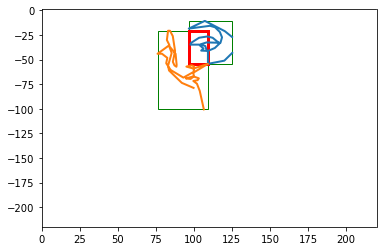

In [ ]:
plot_intersection(s02, s04, extra_bb=bb02.intersection(bb04))

So I can identify an intersection between 2 strokes. But when I take a look at another example, it seems like there's a much less significant overlap:

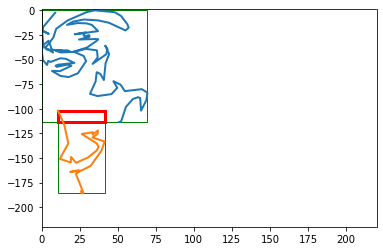

In [ ]:
bb00 = BoundingBox.create(s00)
bb01 = BoundingBox.create(s01)
plot_intersection(s00, s01, extra_bb=bb00.intersection(bb01))

## Intersection over Union (IOU)

What I'd like to do is rank intersections between bounding boxes by their relative importance. How much space does the intersection take up relative to the overall area of the two shapes that are intersecting?

There's a helpful metric here called intersection over union:
```
intersection_area / (shape1_area + shape2_area - intersection_area)
```

For some intuition on why the intersection area gets subtracted in the denominator of that equation, consider this diagram:

![IOU](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_equation.png?lossy=2&strip=1&webp=1)

> source: [Intersection over Union (IoU) for object detection - PyImageSearch](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

In [ ]:
# compute the areas of the two shapes
area_02 = bb02.area()
area_04 = bb04.area()
print(f"Shape 2 area: {area_02}, Shape 4 area: {area_04}")

# compute the area of the intersection
intersection_area = intersection_02_04.area()
print(f"Intersection Area: {intersection_area}")

# divide the intersection area by the sum of each shape minus the intersection area
intersection_over_union = intersection_area / (area_02 + area_04 - intersection_area)
print(f"IOU: {intersection_over_union}")

Shape 2 area: 1247.4105313542163, Shape 4 area: 2645.995725122453
Intersection Area: 423.49904482587266
IOU: 0.12204909785596094


Now I can compare the smaller intersection's IOU value and see a significant difference:

In [ ]:
print(f"IOU of larger overlap: {bb02.iou(bb04)}")

print(f"IOU of smaller overlap: {bb00.iou(bb01)}")

IOU of larger overlap: 0.12204909785596094
IOU of smaller overlap: 0.035704846519125095


### Sanity Check: Non-Intersecting Shapes

I'll pick two shapes that don't overlap, and verify a couple of conditions I expect to be true:
- `BoundingBox.intersection()` should return `None`.
- `BoundingBox.iou()` should return `0.0`.

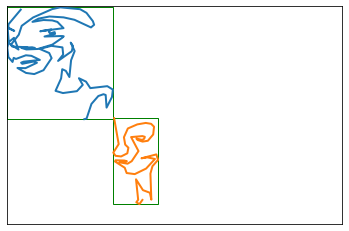

Intersection = None
IOU = 0.0


In [ ]:
plot_strokes([s00, s03], bounding_boxes=True)

bb00 = BoundingBox.create(s00)
bb03 = BoundingBox.create(s03)

print(f"Intersection = {bb00.intersection(bb03)}")

print(f"IOU = {bb00.iou(bb03)}")

## Computing Pairwise Intersections

My goal here is to go through a full scan, and decide which strokes should stay together and which ones should be split out into separate files. The rough idea I have in mind is to take all the strokes, and compute overlaps between each pair of strokes.

In [ ]:
bboxes = [BoundingBox.create(s) for s in s0]
list(combinations(range(len(s0)), 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

In [ ]:
#| exports
def overlapping_bboxes(bboxes):
    max_iou_val = {}
    max_iou_idx = {}
    for a, b in combinations(range(len(bboxes)), 2):
        iou = bboxes[a].iou(bboxes[b])
        if a not in max_iou_val or max_iou_val[a] < iou:
            max_iou_val[a] = iou
            max_iou_idx[a] = b
        if b not in max_iou_val or max_iou_val[b] < iou:
            max_iou_val[b] = iou
            max_iou_idx[b] = a
    return max_iou_val, max_iou_idx

In [ ]:
max_iou_val, max_iou_idx = overlapping_bboxes(bboxes)
print(max_iou_val)
print(max_iou_idx)

{0: 0.035704846519125095, 1: 0.035704846519125095, 2: 0.12204909785596094, 3: 0.0, 4: 0.12204909785596094}
{0: 1, 1: 0, 2: 4, 3: 0, 4: 2}


In [ ]:
n = 2
print(
    f"stroke at index {n} has an intersection with stroke at index {max_iou_idx[n]} with IOU = {max_iou_val[n]}"
)

n = 4
print(
    f"stroke at index {n} has an intersection with stroke at index {max_iou_idx.get(n, None)} with IOU = {max_iou_val.get(n, None)}"
)

stroke at index 2 has an intersection with stroke at index 4 with IOU = 0.12204909785596094
stroke at index 4 has an intersection with stroke at index 2 with IOU = 0.12204909785596094


## Merging Strokes With Sufficient Overlap

Now I want to write a function that'll iterate through the bounding boxes and decide which ones should be merged. This function should accept: 
1. a list of lists of stroke indices
2. a list of bounding boxes corresponding to the space covered by the strokes represented by the indices in each list.

For each set of overlapping bounding boxes, if the IOU exceeds a provided threshold (I've chosen `0.05` as a starting point), I want to merge those stroke indices into a single list.

In [ ]:
#| exports
def single_pass_merge_bboxes(stroke_idxs, bboxes, iou_threshold=0.05, debug=False):
    def log(msg, debug=False):
        if debug:
            print(msg)

    assert len(stroke_idxs) == len(bboxes)
    next_stroke_idxs = []
    next_bboxes = []

    max_iou_val, max_iou_idx = overlapping_bboxes(bboxes)
    bb_idxs = max_iou_val.keys()
    removed = []
    for a in bb_idxs:
        if a in removed:
            log(f"{a}: already joined ", debug)
            continue
        b = max_iou_idx[a]
        iou = max_iou_val[a]
        if iou >= iou_threshold:
            log(
                f"{a}-{b}: JOIN max IOU = {iou} for strokes ({stroke_idxs[a]}, {stroke_idxs[b]})",
                debug,
            )
            # remove the joined strokes from consideration for joins in this pass
            removed.append(a)
            removed.append(b)
            # save the combined stroke lists to return
            next_stroke_idxs.append(stroke_idxs[a] + stroke_idxs[b])
            # save a merged bounding box, representing the union of the lists of strokes.
            next_bboxes.append(bboxes[a].merge(bboxes[b]))
        elif iou == 0:
            log(f"{a}-{b}: NO INTERSECTION", debug)
        else:
            log(f"{a}-{b}: IOU value {iou} is below threshold", debug)

    for i in range(len(bboxes)):
        if i in removed:
            log(f"SKIP: {i} has already been removed in: {removed}", debug)
            continue
        log(f"KEEP: {i}", debug)
        next_stroke_idxs.append(stroke_idxs[i])
        next_bboxes.append(bboxes[i])
    log("---------", debug)
    return next_stroke_idxs, next_bboxes

In this case, the function correctly decides to merge strokes 2 and 4:

0-1: IOU value 0.035704846519125095 is below threshold
1-0: IOU value 0.035704846519125095 is below threshold
2-4: JOIN max IOU = 0.12204909785596094 for strokes ([2], [4])
3-0: NO INTERSECTION
4: already joined 
KEEP: 0
KEEP: 1
SKIP: 2 has already been removed in: [2, 4]
KEEP: 3
SKIP: 4 has already been removed in: [2, 4]
---------


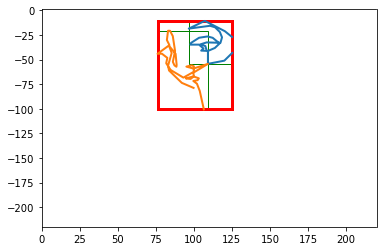

In [ ]:
stroke_idxs = [[i] for i in range(len(s0))]
bboxes = [BoundingBox.create(s) for s in s0]

single_pass_merge_bboxes(stroke_idxs, bboxes, debug=True)

plot_intersection(s02, s04, extra_bb=bb02.merge(bb04))

Now I'll look at a more complex example:

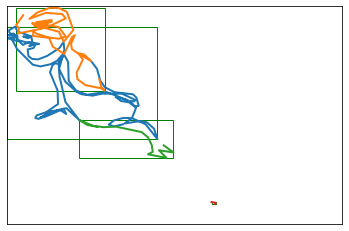

0-1: JOIN max IOU = 0.304835709605367 for strokes ([0], [1])
1: already joined 
2-0: JOIN max IOU = 0.0789861881324346 for strokes ([2], [0])
3-0: NO INTERSECTION
SKIP: 0 has already been removed in: [0, 1, 2, 0]
SKIP: 1 has already been removed in: [0, 1, 2, 0]
SKIP: 2 has already been removed in: [0, 1, 2, 0]
KEEP: 3
---------


([[0, 1], [2, 0], [3]],
 [BBox((0.0, 0.4103792726651996), (98.72127146961232, 133.94363529105254)) (width 98.72127146961232 x height 133.53325601838733),
  BBox((0.0, 19.638976908943352), (109.27638960296453, 152.9782295148018)) (width 109.27638960296453 x height 133.33925260585843),
  BBox((134.2737343533649, 197.9419845429577), (136.92204422299525, 200.00000000000003)) (width 2.648309869630367 x height 2.0580154570423304)])

In [ ]:
s6 = deltas_to_strokes(full_dataset[6])
plot_strokes(s6, bounding_boxes=True)

stroke_idxs = [[i] for i in range(len(s6))]
bboxes = [BoundingBox.create(s) for s in s6]

single_pass_merge_bboxes(stroke_idxs, bboxes, debug=True)

The function correctly decided to merge strokes 0 and 1, but there remains a large overlap with stroke 2. So I'll need to make multiple passes through each drawing, stopping when no more stroke merges have happened in a given iteration.

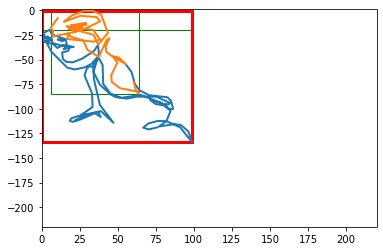

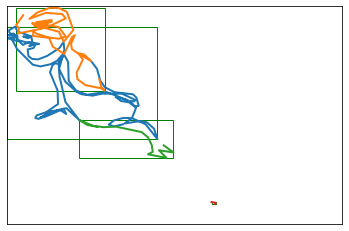

In [ ]:
plot_intersection(s6[0], s6[1], extra_bb=bboxes[0].merge(bboxes[1]))
plot_strokes(s6, bounding_boxes=True)

## Making Multiple Merge Passes

In [ ]:
#| exports
def separate_non_overlapping(strokes, iou_threshold=0.05):
    stroke_idxs = [[i] for i in range(len(strokes))]
    bboxes = [BoundingBox.create(s) for s in strokes]

    next_stroke_idxs, next_bboxes = [], []

    while True:
        next_stroke_idxs, next_bboxes = single_pass_merge_bboxes(
            stroke_idxs, bboxes, iou_threshold=iou_threshold
        )
        if len(next_stroke_idxs) == len(stroke_idxs):
            break
        stroke_idxs = next_stroke_idxs
        bboxes = next_bboxes
    return stroke_idxs, bboxes

[[2, 4], [0], [1], [3]]


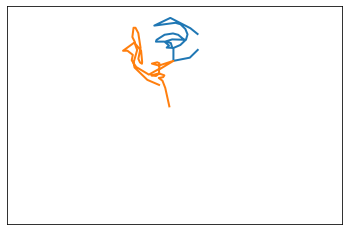

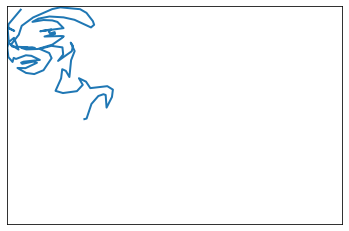

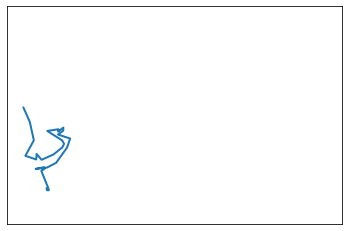

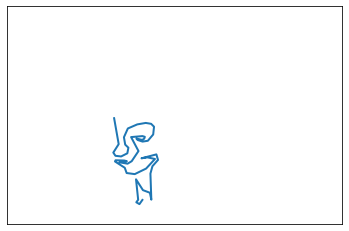

In [ ]:
stroke_groups, bboxes = separate_non_overlapping(s0)
print(stroke_groups)

for sg in stroke_groups:
    strokes = [s0[i] for i in sg]
    plot_strokes(strokes)

Now, to verify that it worked for the problem case above:

[[0, 1, 2, 0], [3]]


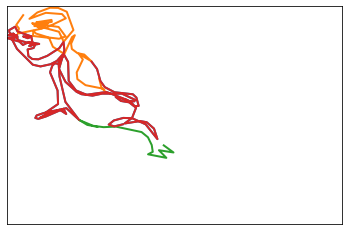

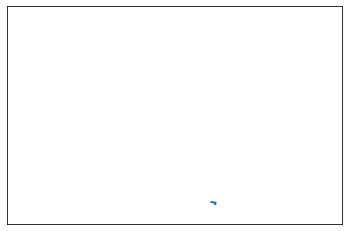

In [ ]:
stroke_groups, bboxes = separate_non_overlapping(s6)
print(stroke_groups)

for sg in stroke_groups:
    strokes = [s6[i] for i in sg]
    plot_strokes(strokes)

One last detail: sometimes there are small bits of writing in the scan (usually page numbers I've recorded).

So I'd like to apply an area threshold, and if a shape's bounding box is below the threshold I can just omit that from the final list of strokes.

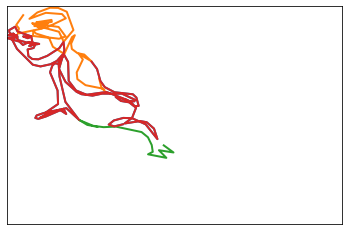

In [ ]:
area_threshold = 500

stroke_groups, bboxes = separate_non_overlapping(s6)
for sg, bb in zip(stroke_groups, bboxes):
    strokes = [s6[i] for i in sg]
    if bb.area() < area_threshold:
        continue
    plot_strokes(strokes)

One last thing: each of the split-out drawings is now much smaller than the available range, and is offset in the coordinate space. I'll rescale the coordinates so each sub-drawing now fits the space. 

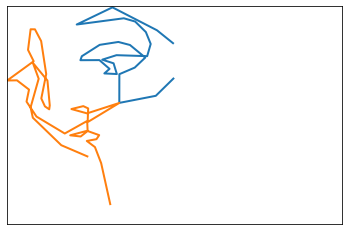

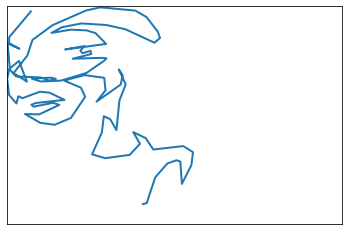

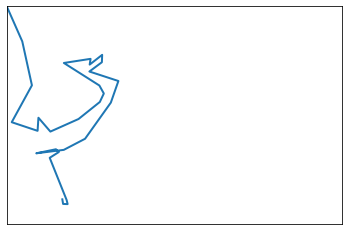

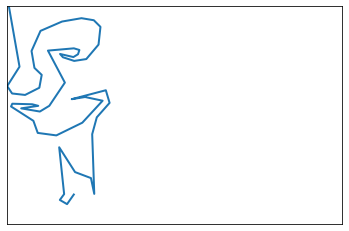

In [ ]:
stroke_groups, bboxes = separate_non_overlapping(s0)
for sg, bb in zip(stroke_groups, bboxes):
    strokes = [s0[i] for i in sg]
    if bb.area() < area_threshold:
        continue
    rescaled = rescale_strokes(strokes, target_size=200)
    plot_strokes(rescaled)

In [ ]:
#| export
def group_and_rescale_overlapping_strokes(orig_strokes, min_area=500, target_size=200):
    stroke_groups, bboxes = separate_non_overlapping(orig_strokes)
    for sg, bb in zip(stroke_groups, bboxes):
        strokes = [orig_strokes[i] for i in sg]
        if bb.area() < min_area:
            continue
        rescaled = rescale_strokes(strokes, target_size=target_size)
        yield rescaled

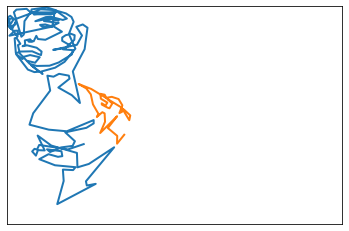

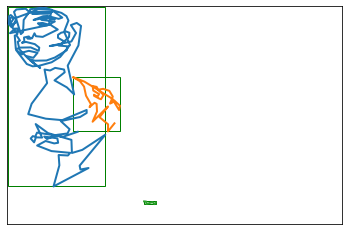

In [ ]:
item = deltas_to_strokes(full_dataset[3])
for s in group_and_rescale_overlapping_strokes(item):
    plot_strokes(s)
# show the original for comparison
plot_strokes(item, bounding_boxes=True)

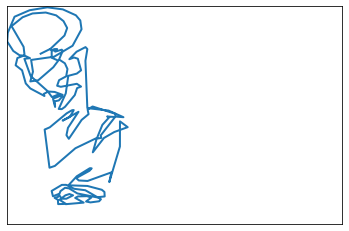

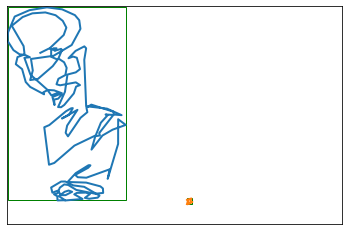

In [ ]:
item = deltas_to_strokes(full_dataset[5])
for s in group_and_rescale_overlapping_strokes(item):
    plot_strokes(s)
# show the original for comparison
plot_strokes(item, bounding_boxes=True)

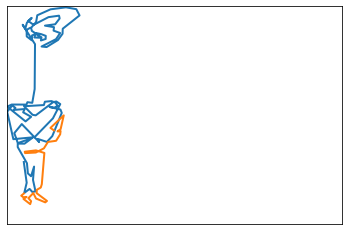

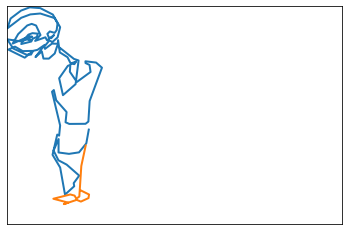

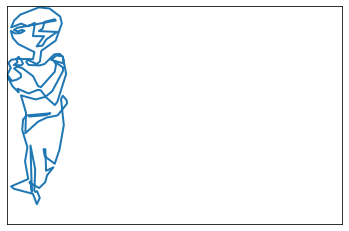

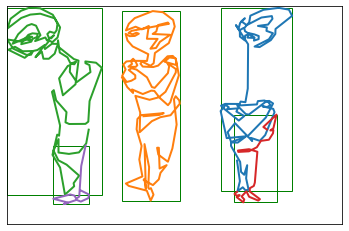

In [ ]:
item = deltas_to_strokes(full_dataset[7])
for s in group_and_rescale_overlapping_strokes(item):
    plot_strokes(s)
# show the original for comparison
plot_strokes(item, bounding_boxes=True)

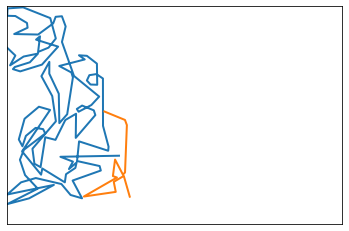

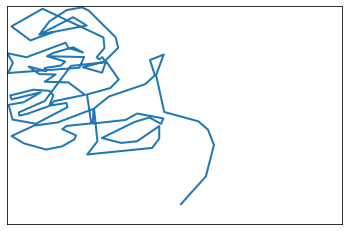

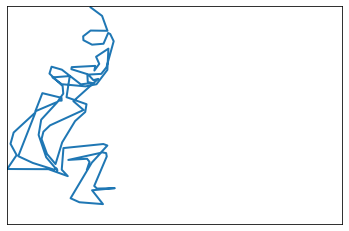

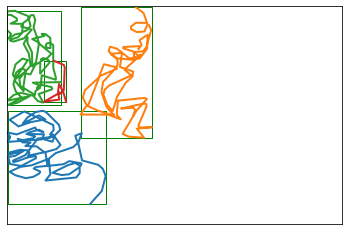

In [ ]:
item = deltas_to_strokes(full_dataset[8])
for s in group_and_rescale_overlapping_strokes(item):
    plot_strokes(s)
# show the original for comparison
plot_strokes(item, bounding_boxes=True)

## Generating a new dataset

In [ ]:
## to use the full dataset:

data_home = singleline_data_home()
input_path = data_home / "stroke3/epoch-20231214/full-v2-eps10.npz"
full_dataset = np.load(
    input_path,
    encoding="latin1",
    allow_pickle=True,
)["arr_0"]

print(len(full_dataset))

no env var SINGLELINE_DATA_HOME, defaulting to: None
1921


In [ ]:
input_path

Path('/Users/al/singleline_data/stroke3/epoch-20231214/full-v2-eps10.npz')

In [ ]:
stroke3_epoch_dir = data_home / "stroke3/epoch-20231214"

debug_dir = stroke3_epoch_dir / "grouped-debug"
final_dir = stroke3_epoch_dir / "grouped-final"
npz_dir = stroke3_epoch_dir / "grouped-npz"

if not os.path.isdir(debug_dir):
    os.makedirs(debug_dir)
if not os.path.isdir(final_dir):
    os.makedirs(final_dir)
if not os.path.isdir(npz_dir):
    os.makedirs(npz_dir)

In [ ]:
output_items = []
for i in range(len(full_dataset)):
    item = deltas_to_strokes(full_dataset[i])
    for j, s in enumerate(group_and_rescale_overlapping_strokes(item)):
        plot_strokes(s, fname=debug_dir / f"{i:04d}_group-{j:02d}.png")
        plot_strokes(
            s, fname=final_dir / f"{i:04d}_group-{j:02d}.png", transparent=True
        )
        output_items.append(s)
    # show the original for comparison
    plot_strokes(item, bounding_boxes=True, fname=debug_dir / f"{i:04d}__overview.png")

new_dataset = np.array(output_items, dtype=object)
new_dataset_deltas = np.array([strokes_to_deltas(s) for s in new_dataset], dtype=object)

np.savez(npz_dir / "all.npz", new_dataset_deltas, encoding="latin1", allow_pickle=True)

split_train_val(new_dataset_deltas, npz_dir / "train_val.npz")

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()

## 